## Analysis and Classification of Song dataset
This notebook contains the instructions for the mini project on classiﬁcation for the course [Statistical Machine Learning](http://www.it.uu.se/edu/course/homepage/sml), 1RT700. The problem is to classify a set of 200 songs, and predict whether Andreas Lindholm(Course Instructor) would like them or not, with the help from a training data set with 750 songs. 
We are expected to (i) try some (or all) classiﬁcation methods from the course and evaluate their performance on the problem, and (ii) make a decision which one to use and ‘put in production’ by uploading your predictions to [this](http://www.it.uu.se/edu/course/homepage/sml/project/submit/) website.

In [1]:
import pandas as pd
import seaborn
import numpy as np
from matplotlib import pyplot as plt

## Dataset Visualisation and Number of features
Make sure to check the path before reading the training and test file. The dataset consist of a total of 750 samples and 13 features and a labe associative to it(14 features in total). Test dataset consist of 200 samples for which we need to predict the label.

In [10]:
train_path = 'data/training_data.csv'
test_path = 'data/songs_to_classify.csv'

In [11]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print('Total number of samples in training dataset: \t%s' % df_train.shape[0])
print('Total number of features: \t%s' % len(df_train.columns.values))
print('Total number of samples in test dataset: \t%s' % df_test.shape[0])

Total number of samples in training dataset: 	750
Total number of features: 	14
Total number of samples in test dataset: 	200


In [9]:
df_train.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
0,0.713,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143,1
1,0.192,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582,1
2,0.333,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199,1
3,0.601,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798,1
4,0.883,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288,1


In [17]:
# Below method checks returns the boolean result for each of the column in dataframe telling whether it has null value or not
def null_column(df):
    return df.isnull().any()

We can check the result returned by null_column function for training dataset that it doesn't have any value as Nan.

In [18]:
null_column(df_train)

acousticness        False
danceability        False
duration            False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
label               False
dtype: bool

## Data Normalization
Normalization refers to the process of standardizing the values of independent features of a dataset. Since many of the machine learning techniques use distance to compute the difference between two or more distinct samples, a feature within these samples that has a broad range of values will dominate the process. In order to avoid this, the range of all features are normalized so that each feature contributes approximately proportionately to the computation.

In [21]:
from sklearn.preprocessing import normalize

# Separate features from their labels
features = [x != 'label' for x in df_train.columns.values]
all_values = df_train.loc[:, features].values
all_labels = df_train.loc[:,['label']].values

# Scale values (mean = 0 and variance = 1)
all_values =  normalize(all_values, axis=1)

## Class Imbalance

Class imbalance refers to the phenomenon where some classes (labels) of a dataset have more samples than others. This is a problem because the machine learning algorithms will tend to focus on the classification of the samples that are overrepresented while ignoring or misclassifying the underrepresented samples.

In [31]:
ones,zeros = df_train.label.value_counts()

print('Percentage of label 1 in training dataset is {}'.format(ones/df_train.shape[0]))
print('Percentage of label 0 in training dataset is {}'.format(zeros/df_train.shape[0]))

Percentage of label 1 in training dataset is 0.6026666666666667
Percentage of label 0 in training dataset is 0.3973333333333333


From the output above we can see the dataset has a bit of class imbalance problem. The Label 1 has 452 samples, while Label 0 has only 298. It is a binary classification problem but still we can check whether this difference in number of samples will affect our result or not.

# Confusion Matrix
Before working with the different machine learning methods which we'll use for classification, let's create a helper method which renders a confusion matrix of a specified model prediction output. A confusion matrix is a table often used to analyze the performance of a classifier on samples for which the true values are known (we'll use it to analyze the performance of the machine learning methods in the test set). Each row in the table represents the instances in an actual class while each column instances in a predicted class

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, labels):
    '''
    Plot confusion matrix of the specified accuracies and labels
    '''
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    
    # Draw ticks
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    
    # Normalize
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [33]:
x_train = pd.concat([df_train[['label']],pd.DataFrame(all_values)],axis=1)
x_train.head()

,label,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,7.121093e-06,0.000005,0.999999,0.000005,8.149807e-06,0.000080,1.118601e-06,-0.000148,0.000000,4.434454e-07,0.001197,0.000040,1.428214e-06
1,1,9.274509e-07,0.000003,1.000000,0.000003,0.000000e+00,0.000019,1.270415e-06,-0.000033,0.000005,1.540921e-07,0.000599,0.000019,2.811336e-06
2,1,1.540240e-06,0.000003,1.000000,0.000002,1.660499e-11,0.000023,5.874189e-07,-0.000043,0.000005,1.350601e-07,0.000647,0.000019,9.204438e-07
3,1,4.405737e-06,0.000006,1.000000,0.000002,1.539442e-06,0.000037,1.348845e-06,-0.000081,0.000007,3.144861e-07,0.000806,0.000029,5.849880e-06
4,1,4.866622e-06,0.000003,1.000000,0.000003,9.534831e-10,0.000033,3.813932e-07,-0.000045,0.000000,1.934524e-07,0.000500,0.000022,1.587301e-06


In [39]:
X = all_values
Y = all_labels
labels_list = np.unique(df_train.loc[:,['label']].values)

# Methods

In [38]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import accuracy_score

train_value, val_value, train_label, val_label = train_test_split(X,Y,test_size=0.25)

C:\Users\212727435\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


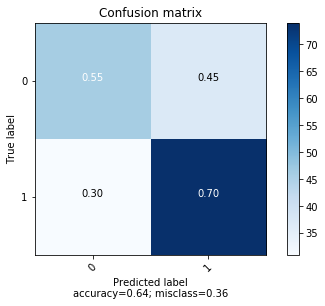

In [40]:
kNNClassifier = neighbors.KNeighborsClassifier(n_neighbors=10).fit(train_value, train_label)
predicted_labels = kNNClassifier.predict(val_value)
knn_pca_acc = accuracy_score(val_label, predicted_labels)
knn_pca_cm = confusion_matrix(val_label, predicted_labels)
plot_confusion_matrix(knn_pca_cm, labels_list)